# Matrix Factorization for Movie Recommendations

1. Asks user to enter a personal identification number.

2. Uses a pre-built model to determine the three best items to recommend that person.

3. Uses another pre-built model which was trained on SVD-reduced data to recommend three items to that person.

4. Prints the estimated standard deviation between the original model and the SVD-reduced model (RMSE between two utility matrices).

__Bonus__: Come up with a metric and train-test-split method to determine which value of k (number of singular values) creates the best SVD-reduced model.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

# Amazon Electronics


In [2]:
dataset = 'electronics'
ratings = pd.read_csv('../data/raw/df_'+dataset+'.csv', usecols=["user_id", "item_id", "rating", "brand", "category"])
ratings.dropna(subset=["brand", "category"], axis=0, inplace=True)
# ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.reset_index(inplace=True, drop=True)
ratings


,item_id,user_id,rating,category,brand
0,1,14,4.0,Computers & Accessories,HP
1,1,42,5.0,Computers & Accessories,HP
2,1,75,5.0,Computers & Accessories,HP
3,1,76,5.0,Computers & Accessories,HP
4,1,77,2.0,Computers & Accessories,HP
...,...,...,...,...,...
331115,9320,1157614,1.0,Computers & Accessories,ebasy
331116,9320,1157622,1.0,Computers & Accessories,ebasy
331117,9320,1157625,5.0,Computers & Accessories,ebasy
331118,9478,1157628,1.0,Headphones,Etre Jeune


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331120 entries, 0 to 331119
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   item_id   331120 non-null  int64  
 1   user_id   331120 non-null  int64  
 2   rating    331120 non-null  float64
 3   category  331120 non-null  object 
 4   brand     331120 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 12.6+ MB


In [4]:
ratings.rating.value_counts()

rating
5.0    191386
4.0     57318
1.0     35521
3.0     26327
2.0     20568
Name: count, dtype: int64

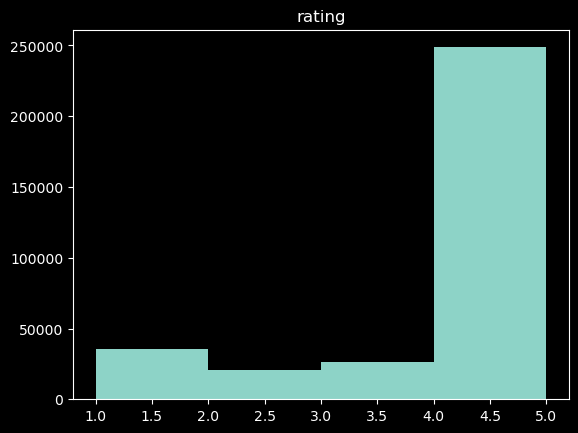

In [5]:
ratings.hist("rating", bins=[1,2,3,4,5], grid=False);

In [6]:
ratings['title'] = ratings['brand'] + ' products in ' + ratings['category']
ratings.drop(columns=["category", "brand"], inplace=True)
ratings

,item_id,user_id,rating,title
0,1,14,4.0,HP products in Computers & Accessories
1,1,42,5.0,HP products in Computers & Accessories
2,1,75,5.0,HP products in Computers & Accessories
3,1,76,5.0,HP products in Computers & Accessories
4,1,77,2.0,HP products in Computers & Accessories
...,...,...,...,...
331115,9320,1157614,1.0,ebasy products in Computers & Accessories
331116,9320,1157622,1.0,ebasy products in Computers & Accessories
331117,9320,1157625,5.0,ebasy products in Computers & Accessories
331118,9478,1157628,1.0,Etre Jeune products in Headphones


# Train Test Split

In [7]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
train_ratings = pd.DataFrame(index=ratings["user_id"].unique(), columns=ratings["item_id"].unique())
test_ratings = train_ratings.copy()

In [8]:
for i in range(len(train)):
    train_ratings.loc[train["user_id"].iloc[i], train["item_id"].iloc[i]] = train["rating"].iloc[i]
for i in range(len(test)):
    test_ratings.loc[test["user_id"].iloc[i], test["item_id"].iloc[i]] = test["rating"].iloc[i]

In [9]:
# train_means = np.mean(train_ratings, axis=0)
train_means = np.nanmean(train_ratings)
train_means

np.float64(4.052881130707901)

In [10]:
train_ratings = train_ratings - train_means
train_ratings 

,1,4,5,6,7,9,11,12,13,14,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,0.947119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,0.947119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,-2.052881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# train_ratings = train_ratings.fillna(train_means, axis=0)
train_ratings = train_ratings.fillna(0)

train_ratings.isna().sum().sum()

/var/folders/4z/t3p0cxjx63gd2x87gr6ps72w0000gn/T/ipykernel_69482/518407943.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_ratings = train_ratings.fillna(0)


np.int64(0)

In [12]:
train_ratings = train_ratings.astype(float)
train_ratings

,1,4,5,6,7,9,11,12,13,14,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
14,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.947119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.947119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,-2.052881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157614,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157622,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157625,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157628,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from scipy.sparse import dia_matrix, csr_matrix, csc_matrix, coo_matrix, bsr_matrix

In [14]:
train_np = train_ratings.to_numpy()
train_np = bsr_matrix(train_np)

# train_sparse = train_demeaned.astype(pd.SparseDtype("float", np.nan))
train_np

<Block Sparse Row sparse matrix of dtype 'float64'
	with 264896 stored elements (blocksize=1x1) and shape (316699, 2207)>

In [15]:
U, sigma, Vt = svds(train_np, k=42)

In [16]:
U = csr_matrix(U)
sigma = np.diag(sigma)
sigma = dia_matrix(sigma)
Vt = csc_matrix(Vt)

In [17]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 563557450 stored elements and shape (316699, 2207)>

In [19]:
predicted_ratings = predicted_ratings.todense()
predicted_ratings

matrix([[ 1.89755114e-21,  2.02494362e-32, -6.76085830e-23, ...,
         -1.86563125e-21, -8.97677581e-31, -9.53645287e-31],
        [ 3.47442661e-13,  4.84671448e-25,  2.63004967e-17, ...,
         -2.75857469e-13, -1.95054881e-24, -2.62294419e-24],
        [ 1.93874123e-21,  1.33518472e-32, -8.13980220e-24, ...,
          4.61796487e-21, -2.63250542e-31, -3.97125044e-31],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.37596321e-16,  1.74724325e-24,  1.06791778e-15, ...,
         -3.24617274e-13, -7.19002279e-23, -1.26057867e-22],
        [ 7.37596321e-16,  1.74724325e-24,  1.06791778e-15, ...,
         -3.24617274e-13, -7.19002279e-23, -1.26057867e-22]],
       shape=(316699, 2207))

In [20]:
predicted_ratings += train_means
# predictions = predictions_shifted.map(lambda x: x + train_means)
predicted_ratings

matrix([[4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113],
        [4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113],
        [4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113],
        ...,
        [4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113],
        [4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113],
        [4.05288113, 4.05288113, 4.05288113, ..., 4.05288113, 4.05288113,
         4.05288113]], shape=(316699, 2207))

In [21]:
predictions = pd.DataFrame(predicted_ratings, columns=train_ratings.columns, index=train_ratings.index)
predictions = np.clip(predictions, 1, 5)
predictions

,1,4,5,6,7,9,11,12,13,14,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
14,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
42,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
75,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
76,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
77,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157614,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1157622,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1157625,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1157628,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881


In [22]:
# Predicted and filter
pred_np = predictions.to_numpy()
train_np = train_ratings.to_numpy()
test_np = test_ratings.to_numpy()

# Filter preds for train
train_pred_np = pred_np[train_ratings.notna()]
train_np = train_np[train_ratings.notna()]

# Filter preds for test
test_pred_np = pred_np[test_ratings.notna()]
test_np = test_np[test_ratings.notna()]

train_pred_np.shape, train_np.shape

((698954693,), (698954693,))

In [23]:
from sklearn.metrics import root_mean_squared_error

print("The training root mean squared error is: " + str(round(root_mean_squared_error(train_np, train_pred_np), 6)))
print("The test root mean squared error is: " + str(round(root_mean_squared_error(test_np, test_pred_np), 6)))

The training root mean squared error is: 4.052935
The test root mean squared error is: 1.369818


# Develop Recommendations

1. Get the user row  
2. Remove what user has reviewed  
3. give them n_recs  

In [24]:
user_predictions = predictions.loc[14, : ].sort_values()
user_predictions

3338    4.052881
162     4.052881
5054    4.052881
7869    4.052881
1780    4.052881
          ...   
6689    4.052881
4969    4.052881
1882    4.052881
3106    4.052881
5041    4.052881
Name: 14, Length: 2207, dtype: float64

In [25]:
rated = ratings.loc[ratings["user_id"] == 14, "item_id"]
not_rated = ratings[~ratings.title.isin(rated)]["item_id"].drop_duplicates()
not_rated

0            1
8            4
9            5
10           6
12           7
          ... 
308890    9537
311162    9540
326816    9551
329327    9555
330892    9556
Name: item_id, Length: 2207, dtype: int64

In [26]:
recommendations = predictions[predictions.index.isin(not_rated.values)]
recommendations

,1,4,5,6,7,9,11,12,13,14,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
14,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
76,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
96,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
104,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
119,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052882,4.052881,4.052881,4.052881,4.052880,4.052881,4.052881,4.052881,4.052881
6774,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
7724,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
7559,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881


In [ ]:
# import pandas as pd

# df = pd.DataFrame({'A': [5, 6, 7], 'B': [15, 16, 17]})

# # Subtracting using the - operator 
# df_subtracted_operator = df - 1

# # Subtracting using the .sub() method
# df_subtracted_method = df.sub(1)

# print("Original DataFrame:")
# print(df)
# print("\nDataFrame after subtracting 1 (using - operator):")
# print(df_subtracted_operator)
# print("\nDataFrame after subtracting 1 (using .sub() method):")
# print(df_subtracted_method)


In [27]:
not_rated = ratings[~ratings.index.isin(rated)]
not_rated


,item_id,user_id,rating,title
0,1,14,4.0,HP products in Computers & Accessories
2,1,75,5.0,HP products in Computers & Accessories
3,1,76,5.0,HP products in Computers & Accessories
4,1,77,2.0,HP products in Computers & Accessories
5,1,96,5.0,HP products in Computers & Accessories
...,...,...,...,...
331115,9320,1157614,1.0,ebasy products in Computers & Accessories
331116,9320,1157622,1.0,ebasy products in Computers & Accessories
331117,9320,1157625,5.0,ebasy products in Computers & Accessories
331118,9478,1157628,1.0,Etre Jeune products in Headphones


In [ ]:
# = not_rated.sort_values(ascending=False).head(3)
recommendations = recommendations.reset_index()
recommendations


,index,1,4,5,6,7,9,11,12,13,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
0,14,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1,76,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
2,96,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
3,104,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
4,119,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,3869,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052882,4.052881,4.052881,4.052881,4.052880,4.052881,4.052881,4.052881,4.052881
1655,6774,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1656,7724,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881
1657,7559,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,...,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881,4.052881


In [ ]:
# result = pd.DataFrame ({
# 'Check out..': recommendations['item_id']
# })

# result

KeyError: 'item_id'

In [ ]:
def where_to_shop(user_id, ratings, predictions, n_recs=3):
    """
    Name: where_to_shop
    Purpose: function that utilizes a partial singular value decomposition of a sparse matrix to recommend content to user
    Inputs:     1. user_id
                2. ratings: DataFrame of item ratings
                3. predictions: DataFrame of predicted ratings by each user_id
                4. n_recs: number of recommendations wanted
    Outputs:  1. DataFrame of recommendations
    Side effects: none
    """
    # filter out movies user has watched
    rated = ratings.loc[ratings["user_id"] == user_id, "item_id"]
    not_rated = ratings[~ratings.index.isin(rated)]

    # sort by rank, return top n_recs recommendations
    recommendations = not_rated.sort_values(ascending=False).head(n_recs)
    recommendations = recommendations.reset_index()

    # rename columns to match function signature
    result = pd. DataFrame ({
    "mean_rating": recommendations[('rating', 'mean' )],
    'Check out..': recommendations['title'],
    'rank': recommendations['rank']
    })

    return result